Лабораторная работа №8. Сверточные нейронные сети (CNN). Компьютерное зрение. Задача классификации изображений


ЗАДАНИЕ №1.
1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Выполните как минимум две аугментации.
3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.
4. Сформулируйте вывод на основе ответов следующих вопросов:
o Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?
o Что означают параметры, которые Вы задаете?
o Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?


ЗАДАНИЕ №2.
1. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip. Выберите 3 любых класса, которые Вам нравятся. Загрузите данные и сформируете датасет.
2. Выполните как минимум две аугментации.
3. С помощью фреймворка Tensorflow загрузите модели InceptionV3 и VGG19. Выполните Transfer Learning и Fine-Tuning этих моделей для распознавания классов. В процессе подготовки CNN, разморозьте какой-либо еще слой, кроме последнего. Сравните ре-зультаты двух моделей CNN на Ваших данных (по метрике accuracy в процессе обучения).
4. Реализуйте сверточный слой (прямое и обратное распространение). Используйте реализацию многослойного персептрона из ЛР №7. Соберите CNN, используя разработанные Вами слои.
5. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации CNN.


ЗАДАНИЕ №3**
Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

In [1]:
import os
import numpy as np
import tensorflow as tf
os.chdir('../data')

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "data3", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


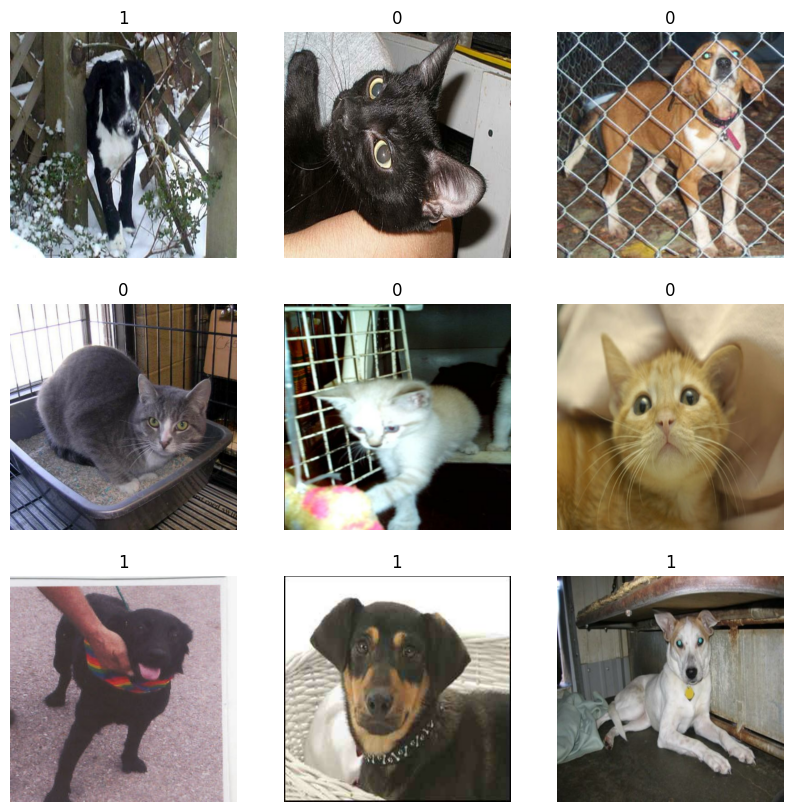

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [2]:
# Создание генератора аугментации
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_datagen = ImageDataGenerator(
    rescale=1./255, # Масштабирование значений пикселей в диапазон [0, 1]
    rotation_range=20, # Случайное вращение изображения на угол в диапазоне [-20, 20]
    width_shift_range=0.2, # Случайное горизонтальное смещение (доля от ширины изображения)
    height_shift_range=0.2, # Случайное вертикальное смещение (доля от высоты изображения)
    shear_range=0.2, # Случайное сдвигание (сдвиг угла сдвига в градусах)
    zoom_range=0.2, # Случайное масштабирование изображения
    horizontal_flip=True) # Случайное отражение изображения по горизонтали

In [5]:
# Создание модели CNN
model = tf.keras.Sequential([
    # сверточный слой Conv2D с функцией активации ReLU для извлечения признаков
    # Сверточный слой Conv2D извлекает пространственные признаки изображений с помощью свертки с ядром на входных данных
    # использует 32 фильтра размером 3x3. Функция активации ReLU используется для добавления нелинейности в модель
    # input_shape=(400, 400, 3) указывает, что входные изображения имеют размер 400x400 пикселей и 3 канала RGB
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)), 
    # Слой пулинга MaxPooling2D уменьшает размерность изображений, улавливая наиболее значимую информацию
    # уменьшает пространственные размерности изображения, выбирая максимальное значение из каждого окна размером 2x2. 
    # Это помогает уменьшить объем вычислений и улучшить инвариантность к масштабу и повороту
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # преобразует многомерный тензор в одномерный вектор. Это нужно, чтобы можно было подать данные на вход полносвязному слою
    tf.keras.layers.Flatten(),
    # Полносвязный слой Dense выполняет операции линейной и нелинейной трансформации выходов предыдущего слоя.
    # 64 нейрона.
    tf.keras.layers.Dense(64, activation='relu'),
    # Выходной слой Dense используется для получения окончательных прогнозов модели. 
    # только один нейрон с функцией активации сигмоида, который представляет вероятности принадлежности к классу собака или кошка.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
# Загрузка изображений из директории и применение генератора аугментации
image_generator = image_datagen.flow_from_directory(
    'data3',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [7]:
# Компиляция модели
model.compile(optimizer='adam', #  Оптимизатор определяет, каким образом будут обновляться веса модели в процессе обучения
              loss='binary_crossentropy', # Функция потерь определяет, как модель измеряет свою производительность в процессе обучения
              metrics=['accuracy']) # Метрики используются для оценки производительности модели

In [8]:
# Обучение модели
model.fit(image_generator,
          epochs=1)

63/63 [==============================] - 144s 2s/step - loss: 1.6872 - accuracy: 0.5145


In [9]:
# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(image_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

63/63 [==============================] - 65s 1s/step - loss: 0.6920 - accuracy: 0.5495
Test loss: 0.6920
Test accuracy: 0.5495


# ЗАДАНИЕ №2.

In [3]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "data4", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 184 files belonging to 3 classes.
Using 148 files for training.
Using 36 files for validation.


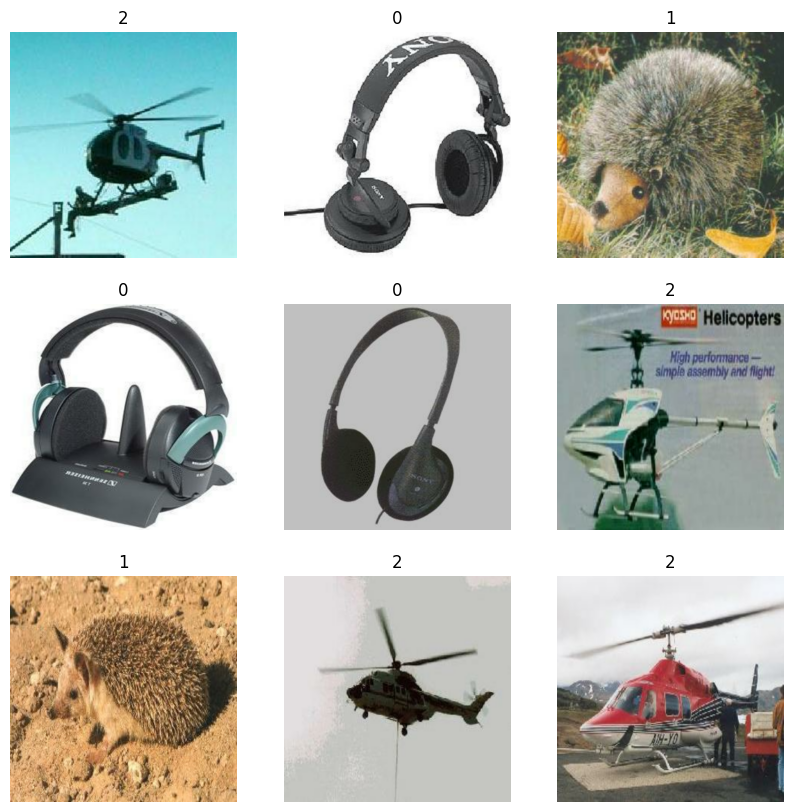

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [5]:
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [6]:
# Загрузка изображений из директории и применение генератора аугментации
image_generator = image_datagen.flow_from_directory(
    'data4',
    target_size=(400, 400),
    batch_size=32)

Found 184 images belonging to 3 classes.


In [7]:
# Загрузка предобученной модели InceptionV3 без последнего слоя Dense
base_model_inception = InceptionV3(include_top=False, weights='imagenet') 
# weights='imagenet' указывает, что должны использоваться веса, полученные в результате обучения на ImageNet

# Заморозка слоев модели InceptionV3
# значит, что веса этих слоев не будут обновляться во время процесса обучения, т.е. эти слои не будут обучаться. 
# Это делается с помощью цикла, в котором каждому слою модели присваивается свойство trainable=False
for layer in base_model_inception.layers:
    layer.trainable = False


In [8]:
# Создание новой модели на основе предобученной InceptionV3
# model_inception = Sequential(): создается новая последовательная модель. 
# Последовательная модель - тип модели, который подразумевает, что слои в модели идут один за другим, последовательно.
model_inception = Sequential()
# добавляется базовая модель InceptionV3, 
# новая модель начинается с уже обученных слоев InceptionV3.
model_inception.add(base_model_inception)
# добавляется слой глобального усреднения. 
# Этот слой преобразует двумерные данные (ширина и высота изображения) в одномерные, усредняя информацию по всему изображению
model_inception.add(GlobalAveragePooling2D())
# добавляется еще один полносвязный слой с тремя нейронами
model_inception.add(Dense(3, activation='softmax'))

In [9]:
# Компиляция модели InceptionV3
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Загрузка предобученной модели VGG19 без последнего слоя Dense
base_model_vgg = VGG19(include_top=False, weights='imagenet')

In [11]:
# Заморозка слоев модели VGG19
for layer in base_model_vgg.layers:
    layer.trainable = False

In [12]:
# Создание новой модели на основе предобученной VGG19
model_vgg = Sequential()
model_vgg.add(base_model_vgg)
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(3, activation='softmax'))

In [13]:
# Компиляция модели VGG19
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Обучение моделей с использованием генератора аугментации
num_epochs = 1
history_inception = model_inception.fit(image_generator, epochs=num_epochs)
history_vgg = model_vgg.fit(image_generator, epochs=num_epochs)

6/6 [==============================] - 86s 14s/step - loss: 1.1544 - accuracy: 0.4457


In [37]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activation_functions):
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(layer_sizes[i], 1) for i in range(1, self.num_layers)]

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def _feed_forward(self, x):
        activations = [x]
        zs = []
        for i in range(self.num_layers - 1):
            weight = self.weights[i]
            bias = self.biases[i]
            activation_fn = self.activation_functions[i]
            z = np.dot(weight, activations[-1]) + bias
            zs.append(z)
            if activation_fn == 'sigmoid':
                a = self._sigmoid(z)
            elif activation_fn == 'tanh':
                a = self._tanh(z)
            elif activation_fn == 'relu':
                a = self._relu(z)
            activations.append(a)
        return activations, zs

    def _backpropagate(self, x, y):
        delta_weights = [np.zeros(weight.shape) for weight in self.weights]
        delta_biases = [np.zeros(bias.shape) for bias in self.biases]
        activations, zs = self._feed_forward(x)
        delta = (activations[-1] - y)  # derivative of the loss function
        for i in range(self.num_layers - 2, -1, -1):
            z = zs[i]
            activation_fn = self.activation_functions[i]
            if activation_fn == 'sigmoid':
                derivative = self._sigmoid_derivative(z)
            elif activation_fn == 'tanh':
                derivative = self._tanh_derivative(z)
            elif activation_fn == 'relu':
                derivative = self._relu_derivative(z)
            delta_weights[i] = np.dot(delta, activations[i].T)
            delta_biases[i] = delta
            delta = np.dot(self.weights[i].T, delta) * derivative
        return delta_weights, delta_biases
        
    def update_parameters(self, delta_weights, delta_biases, learning_rate):
        self.weights = [w - learning_rate * dw for w, dw in zip(self.weights, delta_weights)]
        self.biases = [b - learning_rate * db for b, db in zip(self.biases, delta_biases)]

    def train(self, X_train, y_train, learning_rate, num_epochs):
        for epoch in range(num_epochs):
            for x, y in zip(X_train, y_train):
                x = np.array(x, ndmin=2).T
                y = np.array(y, ndmin=2).T
                delta_weights, delta_biases = self._backpropagate(x, y)
                self.weights = [weight - learning_rate * d_weight for weight, d_weight in zip(self.weights, delta_weights)]
                self.biases = [bias - learning_rate * d_bias for bias, d_bias in zip(self.biases, delta_biases)]

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = np.array(x, ndmin=2).T
            activations, _ = self._feed_forward(x)
            predictions.append(activations[-1])
        return predictions

In [38]:
class ConvLayer:
    def __init__(self, num_filters, kernel_size):
        # принимает количество фильтров и размер ядра свертки. 
        # Фильтры инициализируются случайными значениями, нормализованными по размеру ядра.
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)
    # вспомогательная функция, которая выполняет операцию свертки для одного фильтра и одного входного изображения. 
    # Она возвращает отфильтрованное изображение
    def _convolve(self, input, filter):
        # Получаем размер входного изображения. 
        # входное изображение является квадратным, поэтому берем только одно измерение.
        input_size = input.shape[1]
        # Вычисляем размер выходного изображения после свертки. 
        # Это формула для свертки без заполнения padding и с шагом stride равным 1.
        output_size = input_size - self.kernel_size + 1
        # Инициализируем выходное изображение нулями. 
        # Это будет матрица, в которую будут записываться результаты свертки.
        output = np.zeros((output_size, output_size))
        # два цикла проходят по каждому пикселю в выходном изображении. 
        # Координаты x и y указывают на позицию в выходном изображении, где будет записан результат свертки.
        for x in range(output_size):
            for y in range(output_size):
                # Извлекаем квадратный участок изображения, размер которого равен размеру ядра свертки из входного изображения.
                # Патч соответствует области входного изображения, которая в данный момент обрабатывается.
                patch = input[:, x:x+self.kernel_size, y:y+self.kernel_size]
                # Выполняем операцию свертки для данного патча и фильтра. 
                # путем поэлементного умножения патча и фильтра и последующего суммирования всех элементов. 
                # Результат записывается в соответствующую позицию в выходном изображении.
                output[x, y] = np.sum(patch * filter)
        # Возвращаем выходное изображение после завершения всех операций свертки
        return output

    # функция прямого прохода, которая применяет все фильтры к каждому входному изображению и сохраняет результаты в self.feature_maps. 
    # Она также сохраняет входные данные для использования в обратном проходе.
    def forward_pass(self, input):
        # Сохраняет входные данные для последующего использования в обратном проходе. 
        # Это необходимо для вычисления градиентов во время обратного распространения ошибки.
        self.last_input = input
        # Извлекает количество входных изображений из размерности входных данных.
        num_examples, _, _ = input.shape
        # Вычисляет размер каждой карты признаков которая будет получена после применения свертки к входному изображению
        output_size = input.shape[1] - self.kernel_size + 1
        # Инициализирует массив карт признаков нулями. 
        # Каждая карта признаков - это результат применения одного из фильтров к одному из входных изображений.
        self.feature_maps = np.zeros((num_examples, self.num_filters, output_size, output_size))
        # два цикла проходят через каждый фильтр и каждое входное изображение.
        # Для каждой комбинации фильтра и изображения выполняется свертка.
        for i in range(self.num_filters):
            for j in range(num_examples):
                # Выполняет свертку входного изображения с фильтром. Результат записывается в соответствующую карту признаков.
                self.feature_maps[j, i] = self._convolve(input[j], self.filters[i])
        # Возвращает карты признаков после применения всех фильтров к каждому входному изображению.
        return self.feature_maps

    # функция обратного прохода, которая принимает градиенты от последующего слоя и скорость обучения. 
    # Она вычисляет градиенты по отношению к фильтрам сверточного слоя, используя правило цепи. 
    # Эти градиенты затем могут быть использованы для обновления весов в обратном проходе.
    def backward_pass(self, d_L_d_out, learning_rate):
        # Извлекает количество входных изображений из размерности градиента потерь по отношению к выходу слоя.
        num_examples, _, _, _ = d_L_d_out.shape
        # Инициализирует массив градиентов потерь по отношению к фильтрам нулями. 
        # Этот массив имеет ту же форму, что и массив фильтров, и будет использоваться для накопления градиентов от каждого примера.
        d_L_d_filters = np.zeros(self.filters.shape)
        # четыре цикла проходят через каждый пример, каждый фильтр и каждую позицию в карте признаков. 
        # Для каждой такой комбинации вычисляется градиент потерь по отношению к фильтру.
        for i in range(num_examples):
            for f in range(self.num_filters):
                for x in range(self.last_input.shape[1] - self.kernel_size + 1):
                    for y in range(self.input.shape[2] - self.kernel_size + 1):
                        # Извлекает патч из входного изображения, который соответствует текущей позиции в карте признаков.
                        patch = self.last_input[i, :, x:x+self.kernel_size, y:y+self.kernel_size]
                        # Вычисляет градиент потерь по отношению к фильтру для текущего патча и накапливает его в массиве градиентов. 
                        # Это делается путем умножения градиента потерь по отношению к текущему элементу карты признаков на патч 
                        # и добавления результата к соответствующему элементу в массиве градиентов.
                        d_L_d_filters[f] += d_L_d_out[i, f, x, y] * patch
        # Возвращает градиенты потерь по отношению к фильтрам
        return d_L_d_filters

    # функция обновляет веса фильтров, используя вычисленные градиенты и скорость обучения. 
    # Это делается путем простого вычитания произведения скорости обучения и градиента из текущих весов.
    def update_filters(self, d_L_d_filters, learning_rate):
        self.filters -= learning_rate * d_L_d_filters

In [42]:
class CNN:
    def __init__(self, conv_num_filters, conv_kernel_size, pool_size, mlp_layer_sizes, activation_functions):
        self.conv_layers = [ConvLayer(conv_num_filters, conv_kernel_size)]
        self.fc_layers = MLP(mlp_layer_sizes, activation_functions)

    # Во время прямого прохода данные проходят через каждый слой сети, начиная от входного слоя и заканчивая выходным слоем.
    def forward_pass(self, input):
        # На первом этапе входные данные подаются на сверточный слой . 
        # Метод forward_pass этого слоя производит свертку входных данных с помощью фильтров свертки. 
        # Результатом является набор карт признаков.
        conv_output = self.conv_layers[0].forward_pass(input)
        # Далее полученные карты признаков преобразуются в одномерный вектор. 
        # Это делается для того, чтобы данные могли быть поданы на вход полносвязного слоя, который работает с одномерными векторами. 
        # Операция выпрямления выполняется с помощью метода reshape.
        flattened = conv_output.reshape(conv_output.shape[0], -1)
        # Выпрямленные данные подаются на вход полносвязного слоя. 
        # Метод _feed_forward этого слоя выполняет прямой проход данных через слой, применяя веса и функции активации. 
        # Результатом является выход полносвязного слоя.
        fc_output = self.fc_layers._feed_forward(flattened)
        return fc_output

    def train(self, X_train, y_train, learning_rate, epochs):
        # эпоха один полный проход по всему обучающему набору данных.
        for epoch in range(epochs):
            # внутренний цикл проходит через каждый обучающий пример в наборе данных. 
            for x_batch, y_batch in zip(X_train, y_train):
                # происходит прямой проход обучающего примера через сеть. 
                # это означает, что входные данные подаются на вход сети и проходят через все слои сети до выходного слоя. 
                output = self.forward_pass(x_batch)

                # происходит обратное распространение ошибки. 
                # этот процесс начинается с выходного слоя и движется назад через сеть, обновляя веса и смещения на основе градиента потерь. 
                delta_weights, delta_biases = self.fc_layers._backpropagate(output[-1], y_batch)
                # обновляются веса и смещения полносвязных слоев на основе градиентов
                self.fc_layers.update_parameters(delta_weights, delta_biases, learning_rate)
                
                # сохраняется градиент потерь по выходу сети.
                d_L_d_out = delta_weights[0]
                
                # происходит обратное распространение ошибки для сверточного слоя.
                d_L_d_filters = self.conv_layers[0].backward_pass(d_L_d_out, learning_rate)
                self.conv_layers[0].update_filters(d_L_d_filters, learning_rate)

    def predict(self, X_test):
        # создается пустой список для хранения прогнозов модели.
        predictions = []
        # Цикл проходит через каждый тестовый пример в наборе данных
        for x in X_test:
            # эта строка кода добавляет новую ось к входному массиву. 
            # это нужно, потому что модель ожидает на входе данные в определенной форме. Если входной массив имеет форму (n,), 
            # эта строка преобразует его в форму (1, n). 
            x = x[np.newaxis, :] 
            # происходит прямой проход входного примера через сеть. 
            output = self.forward_pass(x)
            # прогноз добавляется в список прогнозов.
            predictions.append(output)
        # возвращает список всех прогнозов.
        return predictions

In [43]:
# задается количество фильтров которые будут использоваться в сверточных слоях нейронной сети
conv_num_filters = 10 
# задается размер ядра для сверточных слоев.
conv_kernel_size = 3
# первый слой 512 нейронов, второй - 256, и последний 1 нейрон.
mlp_layer_sizes = [512, 256, 1]  
# список функций активации
activation_functions = ['relu', 'relu', 'sigmoid'] 

cnn = CNN(conv_num_filters, conv_kernel_size, 2, mlp_layer_sizes, activation_functions)

In [45]:
# устанавливается скорость обучения для процесса оптимизации
learning_rate = 0.001
# устанавливается количество эпох обучения
num_epochs = 2

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for X_batch, y_batch in image_generator:
        cnn.train(X_batch, y_batch, learning_rate, 1)

Epoch 1/2
Epoch 2/2


# ЗАДАНИЕ №3** Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
# входные данные разбиваются на некоторые области и для каждого окна выбирается максимальное значение.
class MaxPooling2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input):
        self.input = input
        # извлекает размеры входного изображения
        h, w = input.shape
        # вычисляются размеры выходного тензора
        output_h = (h - self.pool_size) // self.stride + 1
        output_w = (w - self.pool_size) // self.stride + 1
        # создается выходной тензор, заполненный нулями
        output = np.zeros((output_h, output_w))

        for i in range(output_h):
            for j in range(output_w):
                # вычисляется максимальное значение и записывается в соответствующую позицию в выходном тензоре
                output[i, j] = np.max(
                    input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size])
        return output

    def backward(self, output_grad):
        h, w = self.input.shape
        # извлекаются размеры градиента от следующего слоя
        output_h, output_w = output_grad.shape
        # создается тензор который будет хранить градиенты которые должны быть переданы обратно к предыдущему слою
        input_grad = np.zeros_like(self.input)

        for i in range(output_h):
            for j in range(output_w):
                # извлекается текущее окно из входного тензора
                window = self.input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                # создается маска, которая показывает, какой элемент в окне был максимальным во время прямого прохода. 
                # путем сравнения каждого элемента окна с максимальным значением в окне.
                mask = (window == np.max(window))
                # градиенты распространяются обратно к входным данным. 
                # Если элемент был максимальным в своем окне во время прямого прохода, его градиент равен градиенту выходного значения этого окна
                # иначе его градиент равен нулю
                input_grad[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] = mask * output_grad[i, j]

        return input_grad

In [61]:
# входные данные разбиваются на некоторые области и для каждого окна вычисляется среднее значение.
class AveragePooling2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input):
        self.input = input
        h, w = input.shape
        output_h = (h - self.pool_size) // self.stride + 1
        output_w = (w - self.pool_size) // self.stride + 1
        output = np.zeros((output_h, output_w))

        for i in range(output_h):
            for j in range(output_w):
                output[i, j] = np.mean(
                    input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size])
        return output

    def backward(self, output_grad):
        h, w = self.input.shape
        output_h, output_w = output_grad.shape
        input_grad = np.zeros_like(self.input)

        for i in range(output_h):
            for j in range(output_w):
                # градиент равномерно распространяется на все значения в окне. 
                # Градиент каждого значения равен градиенту выходного значения этого окна, деленному на количество элементов в окне
                input_grad[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] = output_grad[i, j] / (self.pool_size**2)

        return input_grad

In [62]:
# входные данные разбиваются на некоторые области и для каждого окна выбирается минимальное значение.
class MinPooling2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def forward(self, input):
        self.input = input
        h, w = input.shape
        output_h = (h - self.pool_size) // self.stride + 1
        output_w = (w - self.pool_size) // self.stride + 1
        output = np.zeros((output_h, output_w))

        for i in range(output_h):
            for j in range(output_w):
                output[i, j] = np.min(
                    input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size])
        return output

    def backward(self, output_grad):
        h, w = self.input.shape
        output_h, output_w = output_grad.shape
        input_grad = np.zeros_like(self.input)

        for i in range(output_h):
            for j in range(output_w):
                window = self.input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size]
                mask = (window == np.min(window))
                input_grad[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size] = mask * output_grad[i, j]

        return input_grad

In [63]:
# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [64]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
# Обучение модели
model.fit(image_generator, epochs=1)

63/63 [==============================] - 142s 2s/step - loss: 1.4788 - accuracy: 0.5420


In [66]:
# Оценка модели
loss, accuracy = model.evaluate(image_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

63/63 [==============================] - 66s 1s/step - loss: 0.6925 - accuracy: 0.5720
Loss: 0.6924659609794617
Accuracy: 0.5720000267028809
